In [1]:
import pandas as pd
# from retentioneering import datasets
from typing import Literal, Union, List, Optional, Iterable, get_args, Dict, Tuple, Callable
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from itertools import product
from abc import ABC, abstractmethod

In [2]:
def generate_user_events_data(num_users=1000, num_events=10, num_cities=10, num_os=2, num_rows=5000, seed=42):
    """
    Функция для генерации данных о событиях пользователей.
    """
    # Устанавливаем seed для генератора случайных чисел
    np.random.seed(seed)

    # Создаем список пользователей
    users = ['user' + str(i) for i in range(1, num_users+1)]

    # Создаем список событий
    events = ['event' + str(i) for i in range(1, num_events+1)]

    # Создаем список дат
    dates = [datetime.datetime.now() - datetime.timedelta(days=x) for x in range(180)]

    # Создаем список городов
    cities = ['city' + str(i) for i in range(1, num_cities+1)]

    # Создаем список операционных систем
    os = ['iOS', 'Android']

    statuses = ['status' + str(i) for i in range(1, num_os+1)]

    # Создаем DataFrame
    df = pd.DataFrame({
        'user_id': np.random.choice(users, num_rows),
        'event': np.random.choice(events, num_rows),
        'event_datetime': np.random.choice(dates, num_rows),
        'city': np.random.choice(cities, num_rows),
        'operation_system': np.random.choice(os, num_rows),
        'status': np.random.choice(statuses, num_rows)
    })

    return df

In [3]:
import sys

sys.path.append('d:\\diplom\\product\\insight_pulse')

for path in sys.path:
    print(path)

D:\pythonProg\Python\Python312\python312.zip
D:\pythonProg\Python\Python312\DLLs
D:\pythonProg\Python\Python312\Lib
D:\pythonProg\Python\Python312
d:\diplom\.venv

d:\diplom\.venv\Lib\site-packages
d:\diplom\.venv\Lib\site-packages\win32
d:\diplom\.venv\Lib\site-packages\win32\lib
d:\diplom\.venv\Lib\site-packages\Pythonwin
d:\diplom\product\insight_pulse


In [4]:
from eventframing.eventframe import EventFrame
from eventframing.cols_schema import EventFrameColsSchema
from eventframing.event_type import EventType

from data_preprocessing.data_preprocessor import DataPreprocessor
from data_preprocessing.preprocessors_lib.add_start_end_events import AddStartEndEventsPreprocessor
from data_preprocessing.preprocessors_lib.split_sessions import SplitSessionsPreprocessor

from metrics.metric import MetricKPI, MetricDinamic

from utils.time_units import TimeUnits

## ТЕстирование метрики KPI

In [5]:
data = generate_user_events_data(num_rows=5000)
cols_schema = {'user_id': 'user_id', 'event_timestamp': 'event_datetime', 'event_name': 'event'}
ef = EventFrame(data, cols_schema)
ef.to_dataframe().head()

,user_id,event,event_datetime,city,operation_system,status,event_id,event_type,event_type_index
1357,user1,event2,2024-12-28 09:21:31.751335,city5,Android,status2,1357,raw,2
4234,user1,event6,2024-12-30 09:21:31.751335,city5,Android,status2,4234,raw,2
2760,user1,event2,2025-01-19 09:21:31.751335,city6,iOS,status1,2760,raw,2
4934,user1,event9,2025-01-31 09:21:31.751335,city3,iOS,status1,4934,raw,2
1049,user1,event10,2025-02-28 09:21:31.751335,city1,iOS,status2,1049,raw,2


In [6]:
data = ef.to_dataframe()
data['date'] = data['event_datetime'].dt.date

In [7]:
data.head()

,user_id,event,event_datetime,city,operation_system,status,event_id,event_type,event_type_index,date
1357,user1,event2,2024-12-28 09:21:31.751335,city5,Android,status2,1357,raw,2,2024-12-28
4234,user1,event6,2024-12-30 09:21:31.751335,city5,Android,status2,4234,raw,2,2024-12-30
2760,user1,event2,2025-01-19 09:21:31.751335,city6,iOS,status1,2760,raw,2,2025-01-19
4934,user1,event9,2025-01-31 09:21:31.751335,city3,iOS,status1,4934,raw,2,2025-01-31
1049,user1,event10,2025-02-28 09:21:31.751335,city1,iOS,status2,1049,raw,2,2025-02-28


In [8]:

# period_name = 'date'
hue_cols = ['operation_system', 'status', 'city']
# name = 'city1_users_count'
# formula = lambda x: x[x['city'] == 'city1']['user_id'].nunique()
# formula_kwargs = dict()


# data.groupby([period_name] + hue_cols).apply(lambda data: formula(data, **formula_kwargs), include_groups=False)\
#                 .reset_index().rename(columns={0: name})

def _get_data_pivot_template(self, data: pd.DataFrame, hue_cols: List[str]) -> pd.DataFrame:
    data = data.copy()
    unique_values = [data[col].unique() for col in hue_cols]
        
    # Создаем мультииндекс, представляющий все комбинации
    index = pd.MultiIndex.from_product(unique_values, names=hue_cols)
    
    # Создаем DataFrame с этим мультииндексом
    pivot_template = pd.DataFrame(index=index).reset_index()
    return pivot_template

_get_data_pivot_template(None, data, hue_cols ).shape

(40, 3)

In [8]:
city1_users_count_formula = lambda x: x[x['city'] == 'city1']['user_id'].nunique()
def city_users_count_formula(data, cols_schema,  city='city1'): 
    user_col = cols_schema.user_id
    return data[data['city'] == city][user_col].nunique()

mkpi = MetricKPI(city1_users_count_formula, name='city1_users_count', description='desc')

In [11]:
formula_kwargs = {
    'cols_schema': ef.cols_schema,
    # 'city': 'city7'
}

mkpi.compute_splitted_values(
    ef, 
    hue_cols=['operation_system'], 
    # formula_kwargs=formula_kwargs
)

,operation_system,city1_users_count
0,iOS,226
1,Android,220


In [10]:
mkpi.compute_splitted_values(
    ef.to_dataframe(), 
    hue_cols=['operation_system', 'status'], 
    # formula_kwargs=formula_kwargs
)

,operation_system,status,city1_users_count
0,Android,status2,123
1,Android,status1,111
2,iOS,status2,138
3,iOS,status1,110


In [11]:
mkpi.compute_splitted_values(
    ef.to_dataframe(),  
    # formula_kwargs=formula_kwargs
    )

395

In [12]:
x = ef.to_dataframe()
x[(x['city'] == 'city1') 
#   & (x['operation_system'] == 'Android')
#     & (x['status'] == 'status1')
    ]['user_id'].nunique()

395

## Тестирование метрики динамики


In [9]:
md = MetricDinamic(city1_users_count_formula, name='city1_users_count', description='desc')

In [14]:
ef.cols_schema

EventFrameColsSchema(event_id=event_id, event_type=event_type, event_index=event_type_index, event_name=event, event_timestamp=event_datetime, user_id=user_id, session_id=None, cohort_group=None, custom_cols=[])

In [10]:

(md.compute(ef, period='D', hue_cols=['operation_system', 'status'])['city1_users_count'] == 0).sum()
md.compute(ef, period='M', hue_cols=['operation_system', 'status'])


,Month,operation_system,status,city1_users_count
3,2024-10-01,Android,status1,1
2,2024-10-01,Android,status2,1
1,2024-10-01,iOS,status1,1
0,2024-10-01,iOS,status2,0
7,2024-11-01,Android,status1,16
6,2024-11-01,Android,status2,26
5,2024-11-01,iOS,status1,14
4,2024-11-01,iOS,status2,22
11,2024-12-01,Android,status1,18
10,2024-12-01,Android,status2,17


In [18]:
md = MetricDinamic(city_users_count_formula, name='city_users_count', description='desc')

In [19]:
formula_kwargs = {
    'cols_schema': ef.cols_schema,
    'city': 'city1'
}
data = md.compute(ef, 'D', formula_kwargs=formula_kwargs, hue_cols=['operation_system', 'status'])

## Анализ метрики динамики

In [ ]:
class TimeSeriesAnalysisResult:
    def __init__(self):
        self.smoothed_series = {}
        self.autocorrelation = None
        self.trend_line = None


class TimeSeriesAnalyzer:
    
    @staticmethod
    def smooth_time_series(data: pd.Series, window_size: int) -> pd.Series:
        """
        Применяет скользящее среднее для сглаживания временного ряда.
        
        :param data: pd.Series — временной ряд для сглаживания.
        :param window_size: int — размер окна для скользящего среднего.
        :return: pd.Series — сглаженный временной ряд.
        """
        if window_size < 1:
            return data
        return data.rolling(window=window_size, center=False).mean()

    @staticmethod
    def autocorrelation(x: np.ndarray, lags: int) -> np.ndarray:
        """
        Вычисляет автокорреляцию временного ряда.
        
        :param x: np.ndarray — значения временного ряда.
        :param lags: int — количество лагов для автокорреляции.
        :return: np.ndarray — значения автокорреляции для каждого лага.
        """
        n = len(x)
        mean = np.mean(x)
        c0 = np.var(x) * n
        autocorr = np.correlate(x - mean, x - mean, mode='full')[-n:]
        result = autocorr / c0
        
        return result[:lags + 1]

    @staticmethod
    def trend_line(data: pd.Series) -> pd.Series:
        """
        Рассчитывает линию тренда для временного ряда.
        
        :param data: pd.Series — временной ряд.
        :return: pd.Series — значения линии тренда.
        """
        x_range = np.arange(len(data))
        trend_line_coeficients = np.polyfit(x_range, data, 1)  # 1 for linear regression
        trend_line_func = np.poly1d(trend_line_coeficients)
        return trend_line_func(x_range)
    
    @staticmethod
    def quantitative_trend_analysis(data: pd.Series) -> pd.DataFrame:
        """
        Выполняет количественный анализ тренда временного ряда, возвращает DataFrame с оценками.

        :param data: pd.Series — временной ряд для анализа тренда.
        :return: pd.DataFrame — DataFrame с названиями методов и их оценками тренда.
        """
        results = []

        # 1. Линейная регрессия
        x = np.arange(len(data))
        slope, intercept = np.polyfit(x, data, 1)  # Получаем наклон и пересечение
        results.append(['Linear regression slope', slope])
        
        # 2. Корреляция с постоянно возрастающим рядом
        increasing_series = np.arange(1, len(data) + 1)  # Создание линии, постоянно возрастающей
        correlation = np.corrcoef(data, increasing_series)[0, 1]  # Коэффициент корреляции
        results.append(['Corr with increasing ts', correlation])
        
        # Создание DataFrame из собранных результатов
        trend_df = pd.DataFrame(results, columns=['method', 'result'])
        return trend_df
    
    @staticmethod
    def analyze(data: pd.Series, window_sizes: List[int] = None, lags: int = None, trend_line: bool = False) -> TimeSeriesAnalysisResult:
        result = TimeSeriesAnalysisResult()
        
        # Сглаживание временного ряда
        if window_sizes is not None:
            for window_size in window_sizes:
                smoothed = TimeSeriesAnalyzer.smooth_time_series(data, window_size)
                result.smoothed_series[window_size] = smoothed
                
        # Расчет автокорреляции
        if lags is not None:
            result.autocorrelation = TimeSeriesAnalyzer.autocorrelation(data.values, lags)
            
        # Расчет линии тренда
        if trend_line:
            result.trend_line = TimeSeriesAnalyzer.trend_line(data)
        
        return result

In [101]:
time_series_data = pd.Series(np.random.normal(size=100).cumsum())
time_series_data.head()

0   -0.975061
1   -0.697800
2   -0.922283
3    0.065767
4    3.579443
dtype: float64

In [ ]:
test_data = pd.Series([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
res = pd.DataFrame()
for window in [-1, 0, 7, 10, 16]:
    res[window] = TimeSeriesAnalyzer.smooth_time_series(test_data, window)
res

,-1,0,7,10,16
0,1,1,NaN,NaN,NaN
1,2,2,NaN,NaN,NaN
2,3,3,NaN,NaN,NaN
3,4,4,NaN,NaN,NaN
4,5,5,NaN,NaN,NaN
5,6,6,NaN,NaN,NaN
6,7,7,4.0,NaN,NaN
7,8,8,5.0,NaN,NaN
8,9,9,6.0,NaN,NaN
9,10,10,7.0,5.5,NaN


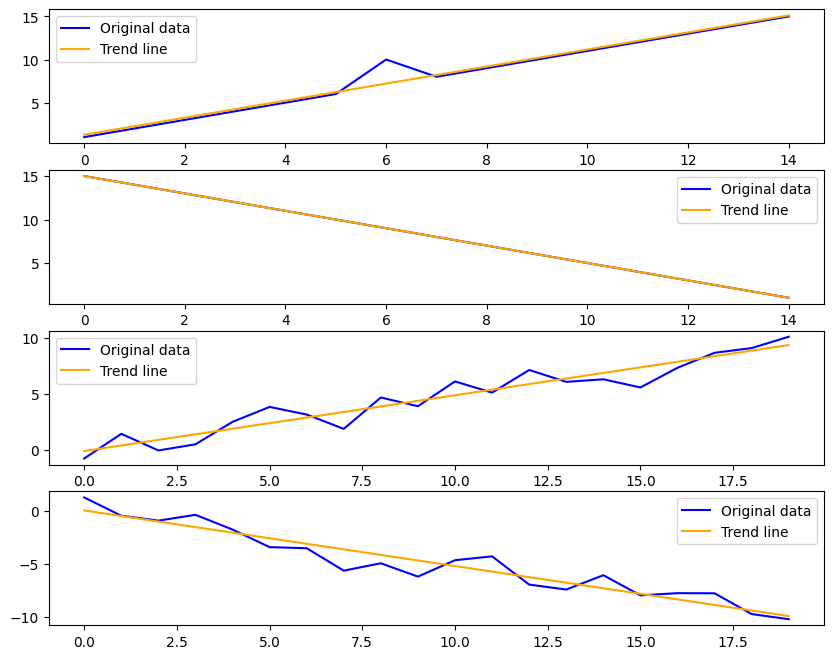

In [120]:
test = [
    [1, 2, 3, 4, 5, 6, 10, 8, 9, 10, 11, 12, 13, 14, 15],
    [15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1],
    np.arange(20) * 0.5 + np.random.normal(loc=0, scale=1, size=20),
    np.arange(20) * -0.5 + np.random.normal(loc=0, scale=1, size=20),

]
quantitive_trend_analysis_res = None


fig, axes = plt.subplots(len(test), 1, figsize=(10, 8))
for i in range(len(test)):
    test_data = test[i]
    x = np.arange(len(test_data))
    trend_line = TimeSeriesAnalyzer.trend_line(test_data)
    
    quantitive_trend_analysis = TimeSeriesAnalyzer.quantitative_trend_analysis(test_data)
    quantitive_trend_analysis['i'] = i
    if quantitive_trend_analysis_res is None:
        quantitive_trend_analysis_res = quantitive_trend_analysis
    else:
        quantitive_trend_analysis_res = pd.concat([quantitive_trend_analysis_res, quantitive_trend_analysis])

    sns.lineplot(x=x,y=test_data, ax=axes[i], label='Original data', color='b')
    sns.lineplot(x=x,y=trend_line, ax=axes[i], label='Trend line', color='orange')

In [121]:
quantitive_trend_analysis_res.set_index(['i', 'method'])

result
i method                           
0 Linear regression slope  0.989286
  Corr with increasing ts  0.985073
1 Linear regression slope -1.000000
  Corr with increasing ts -1.000000
2 Linear regression slope  0.498387
  Corr with increasing ts  0.952990
3 Linear regression slope -0.521947
  Corr with increasing ts -0.955629

In [126]:
test_data = pd.Series(np.arange(20) * 0.5 + np.random.normal(loc=0, scale=1, size=20))
analysis_res = TimeSeriesAnalyzer.analyze(test_data, window_sizes=[7, 14], lags=10, trend_line=True)
pd.DataFrame(analysis_res.smoothed_series)  

,7,14
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
5,NaN,NaN
6,1.591904,NaN
7,1.849060,NaN
8,2.420265,NaN
9,2.886565,NaN


<Axes: ylabel='None'>

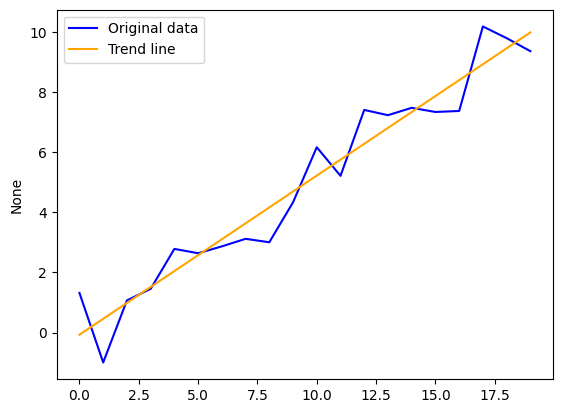

In [128]:
sns.lineplot(x=x,y=test_data, label='Original data', color='b')
sns.lineplot(x=x,y=analysis_res.trend_line, label='Trend line', color='orange')

## Визуализация метрики динамики

In [173]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from typing import Optional, List, Union, Literal

class DinamicMetricPlotter:
    def __init__(self, engine: str = 'plotly'):
        if engine not in ['seaborn', 'plotly']:
            raise ValueError("Engine must be either 'seaborn' or 'plotly'")
        self.engine = engine

    @staticmethod
    def plot(data: pd.DataFrame, dt_col: str, value_col: str,
             aggfunc: Union[str, Callable] = 'sum',
             hue_cols: Optional[List[str]] = None,
             smooth: int = 0,
             mode: Literal['bar', 'line', 'auto'] = 'auto',
             add_text: Union[str, bool] = 'auto',
             engine: str = 'plotly',
             figsize: Tuple[int, int] = (12, 6)):
        if engine not in ['seaborn', 'plotly']:
            raise ValueError("Engine must be either 'seaborn' or 'plotly'")
        
        plot_data = DinamicMetricPlotter._prepare_plot_data(data, dt_col, value_col, hue_cols, aggfunc)
        subsets, labels = DinamicMetricPlotter._prepare_subsets(plot_data, value_col, hue_cols, smooth)
        mode = DinamicMetricPlotter._define_mode(plot_data, dt_col, mode)

        if engine == 'seaborn':
            with sns.axes_style('darkgrid'):
                fig, ax = plt.subplots(figsize=figsize)
                for subset, label in zip(subsets, labels):
                    if mode == 'line':
                        sns.lineplot(data=subset, x=dt_col, y=value_col, label=label, ax=ax)
                    else:
                        sns.barplot(data=subset, x=dt_col, y=value_col,  label=label, ax=ax)
                plt.tight_layout()
        
        else:
            fig = go.Figure()

            # Перебор подмножеств данных и добавление их в фигуру
            for subset, label in zip(subsets, labels):
                if mode == 'line':
                    fig.add_trace(go.Scatter(
                        x=subset[dt_col],
                        y=subset[value_col],
                        mode='lines',  # Можно использовать 'lines' или 'markers' в зависимости от ваших требований
                        name=label
                    ))
                else:
                    fig.add_trace(go.Bar(
                        x=subset[dt_col],
                        y=subset[value_col],
                        name=label,
                        hoverinfo='y+x',  # Отображение информации при наведении
                        showlegend=True
                    ))
            
            # Обновление внешнего вида графика
            fig.update_layout(
                xaxis_title=dt_col,
                yaxis_title=value_col,
                barmode='group' if mode == 'bar' else 'overlay',  # Установка режима для столбчатых графиков
            )

            # Показываем фигуру
            fig.show()

    @staticmethod
    def _plot_analysis(data: pd.DataFrame, dt_col: str, value_col: str,  
                       aggfunc: Union[str, Callable] = 'sum',
                       window_sizes: Optional[List[int]] = None, 
                       lags: Optional[int] = None, 
                       trend_line: bool = False,
                       figsize: Optional[Tuple[int, int]] = None):
        # Подготовка данных
        plot_data = DinamicMetricPlotter._prepare_plot_data(data=data, dt_col=dt_col, value_col=value_col, aggfunc=aggfunc)
        # return plot_data
        
        # Получаем результаты анализа
        analysis_result = TimeSeriesAnalyzer.analyze(
            plot_data[value_col], 
            window_sizes=window_sizes, 
            lags=lags, 
            trend_line=trend_line
        )

        # Установка количества подграфиков
        num_plots = 1 if lags is None else 2
        if figsize is None:
            figsize = (12, 4 * num_plots)
        
        # Настройка фигуры с подграфиками
        with sns.axes_style('darkgrid'):
            gridspec_kw = {'height_ratios': [4, 1] } if num_plots == 2 else {}
            fig, axes = plt.subplots(num_plots, 1, figsize=figsize, sharex=False, gridspec_kw=gridspec_kw)
            
            # График оригинальных данных и сглаженных рядов
            ax = axes if lags is None else axes[0]
            sns.lineplot(data=plot_data, x=dt_col, y=value_col, ax=ax, label='Original Data')
            
            # Добавление сглаженных рядов
            for window_size, smoothed in analysis_result.smoothed_series.items():
                sns.lineplot(x=plot_data[dt_col], y=smoothed, ax=ax, label=f'Smoothed (window={window_size})')
            
            # Добавление линии тренда, если указано
            if trend_line and analysis_result.trend_line is not None:
                sns.lineplot(x=plot_data[dt_col], y=analysis_result.trend_line, ax=ax, label='Trend Line', color='red')

            ax.set_title('Time Series Analysis')
            ax.legend()
            
            if lags is not None:
                ax2 = axes[1]
                autocorr_data = analysis_result.autocorrelation
                # Создание вертикальных линий и маркеров 'o'
                ax2.scatter(np.arange(len(autocorr_data)), autocorr_data, color='b', marker='o')  # Маркеры 'o'
                for i, value in enumerate(autocorr_data):
                    ax2.vlines(x=i, ymin=0, ymax=value, color='b')  # Вертикальные линии
                
                ax2.set_title('Autocorrelation')
                ax2.set_ylabel('Autocorrelation')
                ax2.set_xlabel('Lags')
                ax2.axhline(0, color='b', linewidth=0.5, alpha=0.5)  # Горизонтальная линия на уровне 0
                # ax2.set_xticks(np.arange(len(autocorr_data)))  # Установка меток по оси X
                
                plt.tight_layout()
                plt.show()
        

    @staticmethod
    def smooth_time_series(data: pd.Series, window_size: int) -> pd.Series:
        """
        Применяет скользящее среднее для сглаживания временного ряда.
        
        :param data: pd.Series — временной ряд для сглаживания.
        :param window_size: int — размер окна для скользящего среднего.
        :return: pd.Series — сглаженный временной ряд.
        """
        if window_size < 1:
            return data
        # Применяем скользящее среднее
        return data.rolling(window=window_size, center=False).mean()
    
    @staticmethod
    def _prepare_plot_data(data: pd.DataFrame, dt_col: str, value_col: str, hue_cols: Optional[List[str]] = None, 
                           aggfunc: Union[str, Callable] = 'sum') -> pd.DataFrame:
        if isinstance(hue_cols, str):
            hue_cols = [hue_cols]
        elif hue_cols is None or len(hue_cols) == 0:
            hue_cols = []         

        # Agg data. If there are only one value in each group then return value else return aggregation result
        data = data.groupby([dt_col] + hue_cols).agg(**{
            value_col: (value_col, aggfunc)
        }).reset_index()
        return data

    @staticmethod
    def _prepare_subsets(data: pd.DataFrame, value_col: str,  hue_cols: Optional[List[str]] = None, 
                         smooth: int = 0) -> Tuple[List[pd.DataFrame], List[str]]:
        if hue_cols is None or len(hue_cols) == 0:
            data.loc[:, value_col] = DinamicMetricPlotter.smooth_time_series(data[value_col], smooth)
            return [data], ['']
        
        subsets = []
        labels = []
        if len(hue_cols) == 1:
            unique_hues = data[hue_cols[0]].unique()
            for hue in unique_hues:
                subset = data[data[hue_cols[0]] == hue]
                subset.loc[:, value_col] = DinamicMetricPlotter.smooth_time_series(subset[value_col], smooth)
                subsets.append(subset)
                labels.append(hue)
        else:
            unique_combinations = data[hue_cols].drop_duplicates()
            for _, combo in unique_combinations.iterrows():
                combo_label  = ' & '.join(combo.apply(lambda x: f"{combo.index[combo == x][0]}={x}"))
                subset = data[(data[hue_cols] == combo).all(axis=1)]
                subset.loc[:, value_col] = DinamicMetricPlotter.smooth_time_series(subset[value_col], smooth)
                subsets.append(subset)
                labels.append(combo_label)
        return subsets, labels
    
    @staticmethod
    def _define_mode(data: pd.DataFrame, dt_col: str, mode: Literal['bar', 'line', 'auto']) -> Literal['bar', 'line']:
        return 'line'
        if mode == 'auto':
            unique_x_values = data[dt_col].nunique()
            return 'line' if unique_x_values > 20 else 'bar'
        return mode
        
            

In [174]:
plotter = DinamicMetricPlotter('seaborn')

In [131]:
md = MetricDinamic(city1_users_count_formula, name='city1_users_count', description='desc')
d = md.compute(ef, 'D',  hue_cols=['operation_system', 'status'])

dt_col = 'date'
value_col = 'city1_users_count'
aggfunc = 'sum'



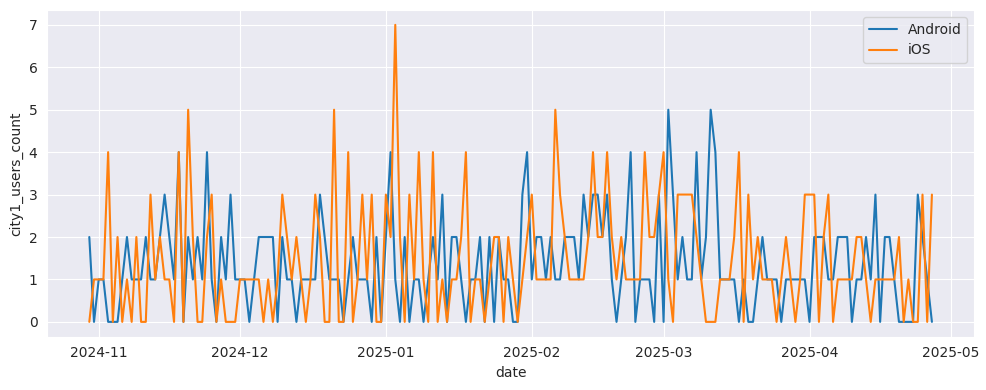

In [142]:
plotter.plot(
    d, 
    dt_col,
    value_col,
    hue_cols=['operation_system'], 
    aggfunc='sum', 
    mode='line', 
    smooth=0, 
    engine='seaborn',
    figsize=(10, 4)
)

In [156]:
md = MetricDinamic(city1_users_count_formula, name='city1_users_count', description='desc')
d = md.compute(ef, 'M',  hue_cols=['operation_system', 'status'])
dt_col = 'Month'

plotter.plot(
    d, 
    dt_col,
    value_col,
    hue_cols=['operation_system', 'status'], 
    aggfunc='mean', 
    mode='auto', 
    smooth=1, 
    engine='plotly',
    figsize=(10, 4)
)

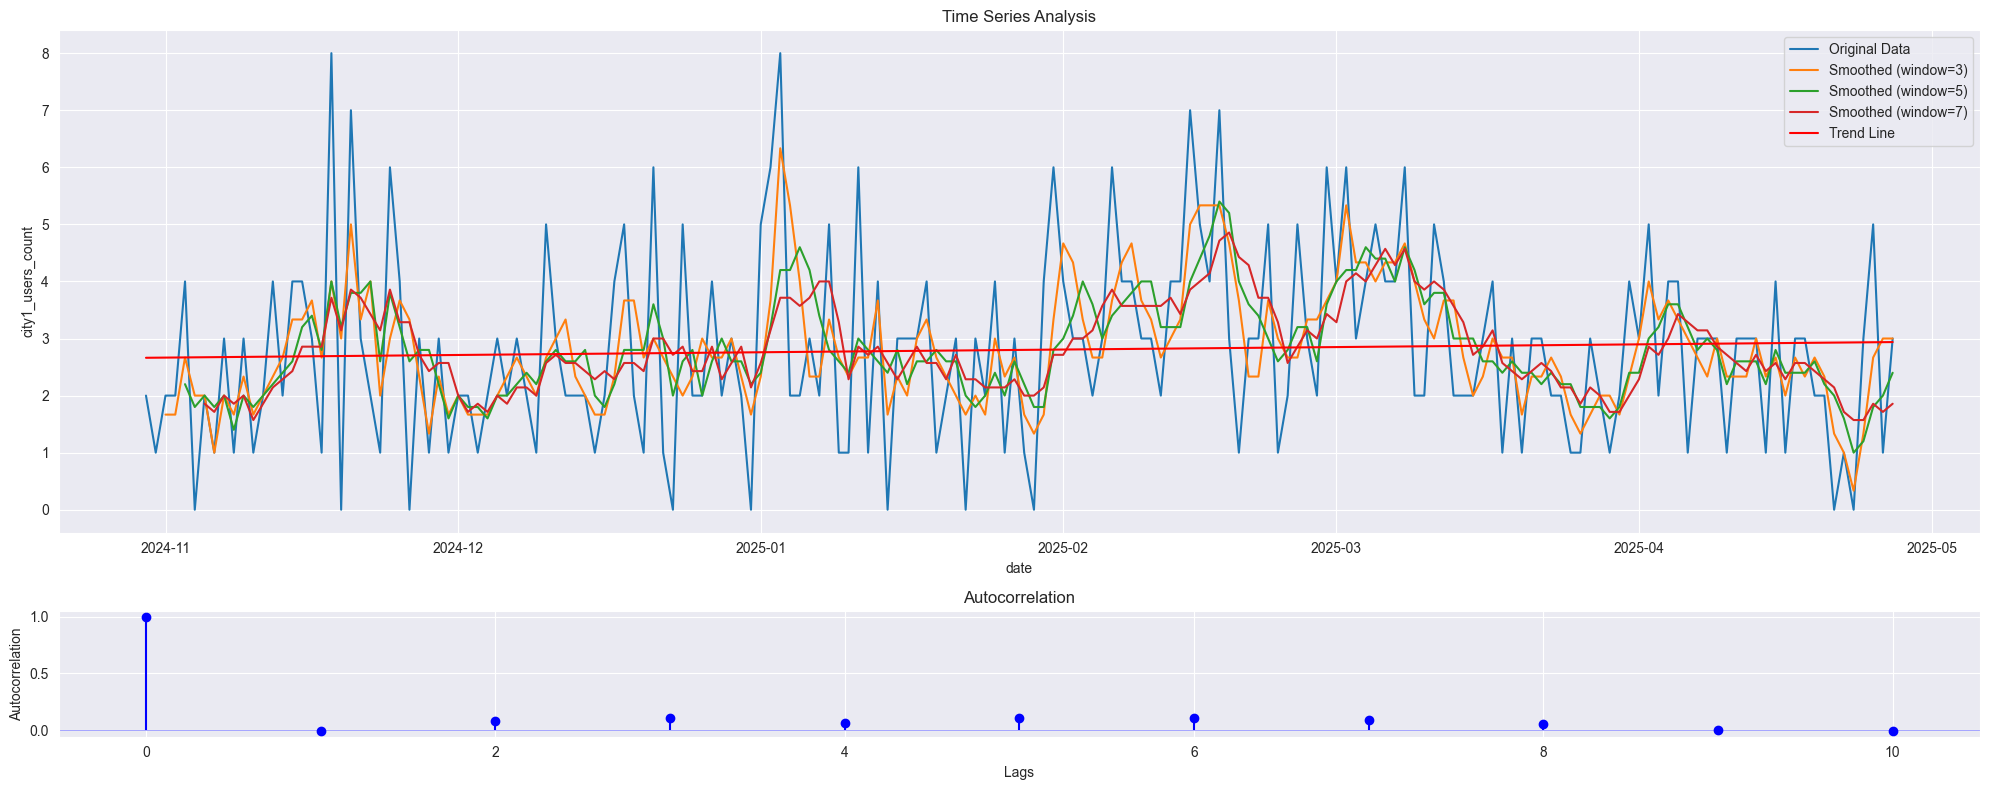

In [175]:
md = MetricDinamic(city1_users_count_formula, name='city1_users_count', description='desc')
d = md.compute(ef, 'D')
dt_col = 'date'

plotter._plot_analysis(
    d, 
    dt_col,
    value_col, 
    aggfunc='sum',
    figsize=(20, 8),
    window_sizes=[3, 5, 7],
    trend_line=True,
    lags=10
)

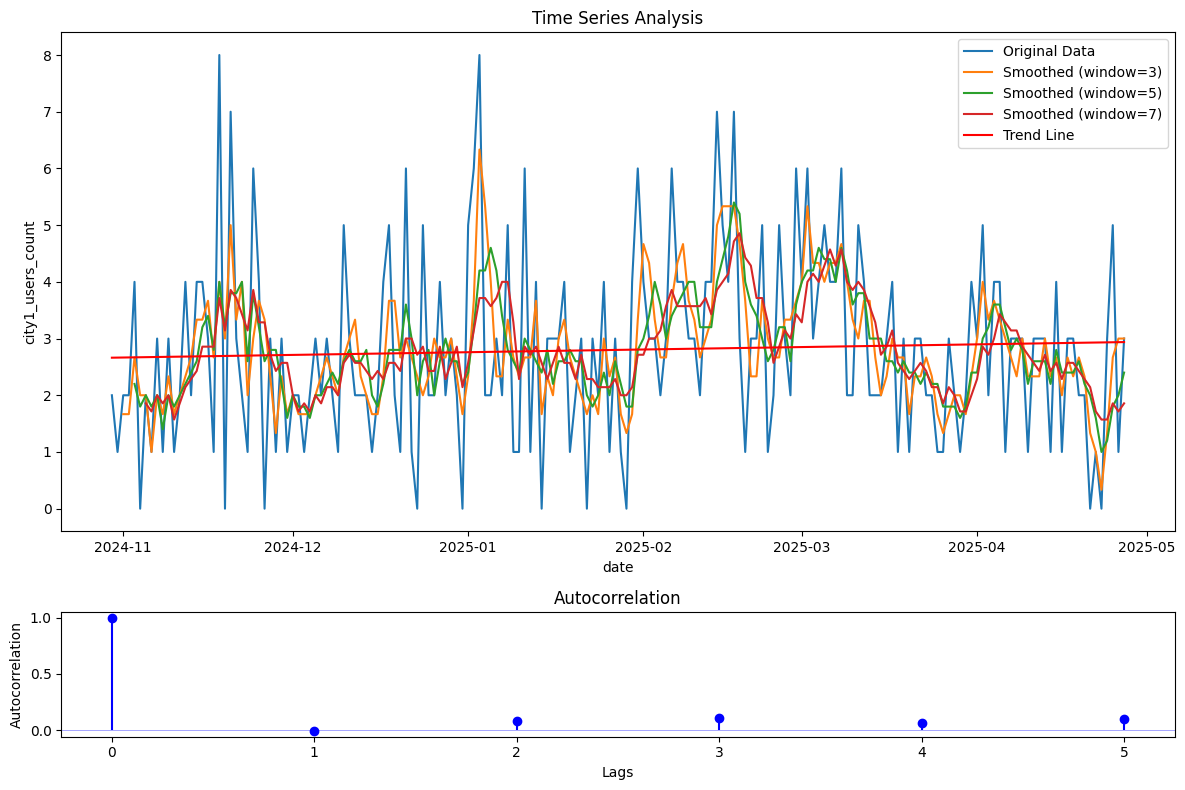

In [99]:
md = MetricDinamic(city1_users_count_formula, name='city1_users_count', description='desc')
d = md.compute(ef, 'D',  hue_cols=['operation_system', 'status'])

dt_col = 'date'
value_col = 'city1_users_count'
aggfunc = 'sum'

plotter = DinamicMetricPlotter('seaborn')
# plotter.plot(
#     d, 
#     dt_col,
#     value_col,
#     # hue_cols=['operation_system'], 
#     aggfunc='sum', 
#     mode='line', 
#     smooth=0, 
#     engine='seaborn',
#     figsize=(10, 4)
# )
plotter._plot_analysis(
    d, 
    dt_col,
    value_col,
    # hue_cols=['operation_system'], 
    window_sizes=[3, 5, 7],
    lags=5,
    trend_line=True
)

In [89]:
d[d['date'] > '2025-01-01'].head(10)

,date,operation_system,status,city1_users_count
259,2025-01-02,Android,status1,1.0
258,2025-01-02,Android,status2,3.0
257,2025-01-02,iOS,status1,1.0
256,2025-01-02,iOS,status2,1.0
263,2025-01-03,Android,status1,1.0
262,2025-01-03,Android,status2,0.0
261,2025-01-03,iOS,status1,4.0
260,2025-01-03,iOS,status2,3.0
267,2025-01-04,Android,status1,0.0
266,2025-01-04,Android,status2,0.0


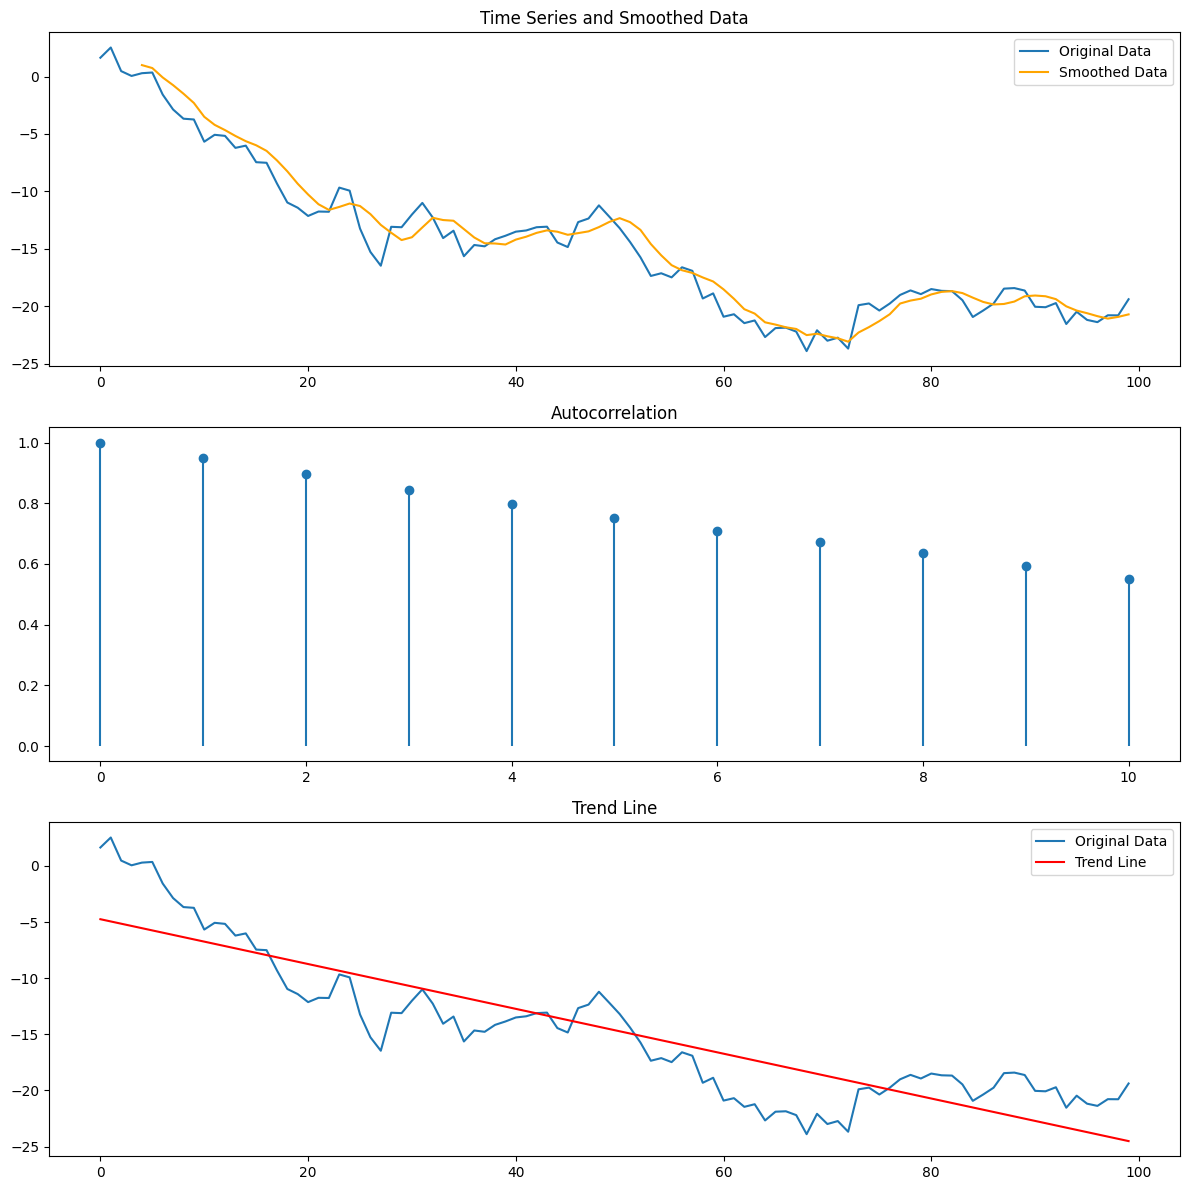

In [35]:
TimeSeriesAnalyzer.quantitative_trend_analysis(time_series_data)

,method,result
0,Linear regression slope,0.042170
1,Corr with increasing ts,0.568088


In [28]:
import statsmodels.api as sm

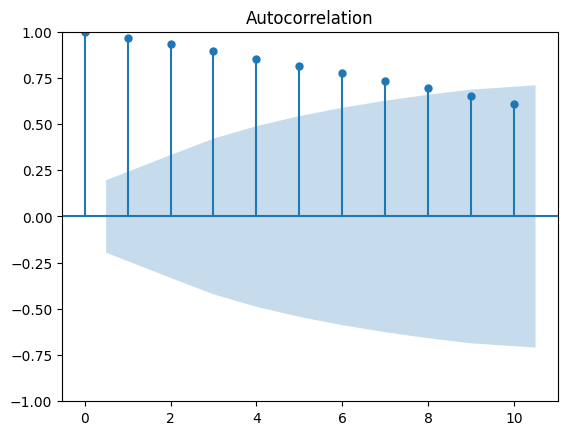

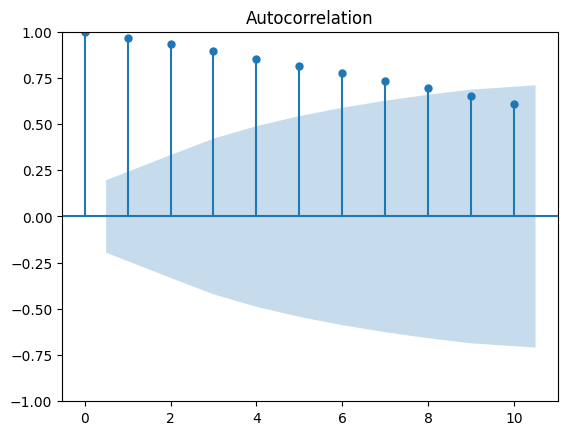

In [31]:
sm.graphics.tsa.plot_acf(time_series_data, lags=10)

In [26]:
!pip install statsmodels

  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   ------- -------------------------------- 1.8/9.8 MB 7.2 MB/s eta 0:00:02
   ----------------------------- ---------- 7.3/9.8 MB 16.2 MB/s eta 0:00:01
   ---------------------------------------- 9.8/9.8 MB 17.0 MB/s eta 0:00:00
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip
